In [1]:
# ! pip install datasets peft scikit-learn
# ! pip install matplotlib
# ! pip install -U adapters


#########  Not necessary  #############
# ! pip install --upgrade transformers
# ! pip install -U accelerate
# ! pip install -U transformers
# ! pip install transformers[sentencepiece]

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#  Setting the working directory
import os
if os.getcwd() != '/home/rahpon/projects/caste':
    os.chdir('/home/rahpon/projects/caste')
    cwd = os.getcwd()
    print(cwd)
cwd = os.getcwd()
print(cwd)

/home/rahpon/projects/caste
/home/rahpon/projects/caste


In [3]:
# import pandas as pd
# import json

# df1 = pd.read_csv('DataSplit/bloom/train.csv')
# df2 = pd.read_csv('DataSplit/bloom/val.csv')
# df3 = pd.read_csv('DataSplit/bloom/test.csv')


# dict1 = df1.to_dict('records')
# dict2 = df2.to_dict('records')
# dict3 = df3.to_dict('records')


# merged_dict = {'train': dict1, 'val': dict2, 'test': dict3}

# with open('DataSplit/bloom/merged.json', 'w') as f:
#     json.dump(merged_dict, f)

In [ ]:
# import json
# from datasets import load_dataset

# # Open the JSON file
# with open('DataSplit/merged.json','r') as f:
#     # Load the JSON data from the file
#     data1 = json.load(f)

# print(data1['train'][0])

# data_path = 'DataSplit/merged.json'

# if data_path.endswith(".json"):  # todo: support jsonl
#     data2 = load_dataset("json", data_files=data_path)
#     print('yes')
# else:
#     data2 = load_dataset(data_path)
#     print('no')
# print(data2)

## New code

In [3]:
import os
import sys
from typing import List

import fire
import torch
import transformers
from datasets import load_dataset
from typing import List, Optional, Union

"""
Unused imports:
import torch.nn as nn
import bitsandbytes as bnb
"""
sys.path.append(os.path.join(os.getcwd(), "LLM-Adapters/peft/src"))

from peft import (  # noqa: E402
    LoraConfig,
    BottleneckConfig,
    PrefixTuningConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, AutoModel  # noqa: F402

In [4]:
def generate_prompt(data_point):
    # sorry about the formatting disaster gotta move fast
    # if data_point["text"]:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. 

                ### Instruction:
                {data_point["instruction"]}
                
                ### Input:
                {data_point["texts"]}
                
                ### Response:
                {data_point["labels"]}""" # noqa: E501
    # else:
    #     return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.  

    #             ### Instruction:
    #             {data_point["instruction"]}
                
    #             ### Response:
    #             {data_point["label"]}""" # noqa: E501


In [5]:
# def generate_prompt(data_point):
#     try:
#         return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. 

#                 ### Instruction:
#                 {data_point["instruction"]}

#                 ### Input:
#                 {data_point["texts"]}

#                 ### Response:
#                 {data_point["labels"]}"""
#     except KeyError as e:
#         print(f"KeyError: {e}")
#         print(f"Available keys: {data_point.keys()}")
#         raise

In [5]:
def train(
        # model/data params
        base_model: str = "",  # the only required argument
        data_path: str = "yahma/alpaca-cleaned",
        output_dir: str = "./lora-alpaca",
        adapter_name: str = "bottleneck",
        load_8bit : bool = False,
        # training hyperparams
        batch_size: int = 8,
        micro_batch_size: int = 4,
        num_epochs: int = 3,
        learning_rate: float = 3e-4,
        cutoff_len: int = 256,
        val_set_size: int = 2000,
        use_gradient_checkpointing: bool = False,
        eval_step: int = 200,
        save_step: int = 1000,
        # lora hyperparams
        lora_r: int = 8,
        lora_alpha: int = 16,
        lora_dropout: float = 0.05,
        lora_target_modules: List[str] = None,
        # bottleneck adapter hyperparams
        bottleneck_size: int = 256,
        non_linearity: str = "tanh",
        adapter_dropout: float = 0.0,
        use_parallel_adapter: bool = False,
        use_adapterp: bool = False,
        target_modules: List[str] = None,
        scaling: Union[float, str] = 1.0,
        # prefix tuning hyperparams
        num_virtual_tokens: int = 30,
        # llm hyperparams
        train_on_inputs: bool = True,  # if False, masks out inputs in loss
        group_by_length: bool = False,  # faster, but produces an odd training loss curve
        # wandb params
        wandb_project: str = "",
        wandb_run_name: str = "",
        wandb_watch: str = "",  # options: false | gradients | all
        wandb_log_model: str = "",  # options: false | true
        resume_from_checkpoint: str = None,  # either training checkpoint or final adapter
):
    print(
        f"Finetuning model with params:\n"
        f"base_model: {base_model}\n"
        f"data_path: {data_path}\n"
        f"output_dir: {output_dir}\n"
        f"batch_size: {batch_size}\n"
        f"micro_batch_size: {micro_batch_size}\n"
        f"num_epochs: {num_epochs}\n"
        f"learning_rate: {learning_rate}\n"
        f"cutoff_len: {cutoff_len}\n"
        f"val_set_size: {val_set_size}\n"
        f"use_gradient_checkpointing: {use_gradient_checkpointing}\n"
        f"lora_r: {lora_r}\n"
        f"lora_alpha: {lora_alpha}\n"
        f"lora_dropout: {lora_dropout}\n"
        f"lora_target_modules: {lora_target_modules}\n"
        f"bottleneck_size: {bottleneck_size}\n"
        f"non_linearity: {non_linearity}\n"
        f"adapter_dropout: {adapter_dropout}\n"
        f"use_parallel_adapter: {use_parallel_adapter}\n"
        f"use_adapterp: {use_adapterp}\n"
        f"train_on_inputs: {train_on_inputs}\n"
        f"scaling: {scaling}\n"
        f"adapter_name: {adapter_name}\n"
        f"target_modules: {target_modules}\n"
        f"group_by_length: {group_by_length}\n"
        f"wandb_project: {wandb_project}\n"
        f"wandb_run_name: {wandb_run_name}\n"
        f"wandb_watch: {wandb_watch}\n"
        f"wandb_log_model: {wandb_log_model}\n"
        f"resume_from_checkpoint: {resume_from_checkpoint}\n"
    )
    assert (
        base_model
    ), "Please specify a --base_model, e.g. --base_model='decapoda-research/llama-7b-hf'"
    gradient_accumulation_steps = batch_size // micro_batch_size

    device_map = "auto"
    world_size = int(os.environ.get("WORLD_SIZE", 1))
    ddp = world_size != 1
    if ddp:
        device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
        gradient_accumulation_steps = gradient_accumulation_steps // world_size

    # Check if parameter passed or if set within environ
    use_wandb = len(wandb_project) > 0 or (
            "WANDB_PROJECT" in os.environ and len(os.environ["WANDB_PROJECT"]) > 0
    )
    # Only overwrite environ if wandb param passed
    if len(wandb_project) > 0:
        os.environ["WANDB_PROJECT"] = wandb_project
    if len(wandb_watch) > 0:
        os.environ["WANDB_WATCH"] = wandb_watch
    if len(wandb_log_model) > 0:
        os.environ["WANDB_LOG_MODEL"] = wandb_log_model

    if load_8bit:
        model = AutoModelForCausalLM.from_pretrained(
            base_model,
            load_in_8bit=load_8bit,
            torch_dtype=torch.float16,
            device_map=device_map,
            trust_remote_code=True,
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            base_model,
            load_in_8bit=False,
            torch_dtype=torch.float16,
            device_map={"": int(os.environ.get("LOCAL_RANK") or 0)},
            trust_remote_code=True,
        )

    if model.config.model_type == "llama":
        # Due to the name of transformers' LlamaTokenizer, we have to do this
        tokenizer = LlamaTokenizer.from_pretrained(base_model)
    else:
        tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

    tokenizer.pad_token_id = (
        0  # unk. we want this to be different from the eos token
    )
    tokenizer.padding_side = "left"  # Allow batched inference

    def tokenize(prompt, add_eos_token=True):
        # there's probably a way to do this with the tokenizer settings
        # but again, gotta move fast
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=False,
            return_tensors=None,
        )
        if (
                result["input_ids"][-1] != tokenizer.eos_token_id
                and len(result["input_ids"]) < cutoff_len
                and add_eos_token
        ):
            result["input_ids"].append(tokenizer.eos_token_id)
            if "chatglm" not in base_model:
                result["attention_mask"].append(1)

        result["labels"] = result["input_ids"].copy()

        if "chatglm" in base_model:
            return {"input_ids": result["input_ids"], "labels": result["labels"]}
        else:
            return result

    def generate_and_tokenize_prompt(data_point):
        full_prompt = generate_prompt(data_point)
        tokenized_full_prompt = tokenize(full_prompt)
        if not train_on_inputs:
            user_prompt = generate_prompt({**data_point, "output": ""})
            tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
            user_prompt_len = len(tokenized_user_prompt["input_ids"])

            tokenized_full_prompt["labels"] = [
                                                  -100
                                              ] * user_prompt_len + tokenized_full_prompt["labels"][
                                                                    user_prompt_len:
                                                                    ]  # could be sped up, probably
        return tokenized_full_prompt

    model = prepare_model_for_int8_training(model, use_gradient_checkpointing=use_gradient_checkpointing)
    if adapter_name == "lora":
        config = LoraConfig(
            r=lora_r,
            lora_alpha=lora_alpha,
            target_modules=target_modules,
            lora_dropout=lora_dropout,
            bias="none",
            task_type="CAUSAL_LM",
        )
    elif adapter_name == "bottleneck":
        config = BottleneckConfig(
            bottleneck_size=bottleneck_size,
            non_linearity=non_linearity,
            adapter_dropout=adapter_dropout,
            use_parallel_adapter=use_parallel_adapter,
            use_adapterp=use_adapterp,
            target_modules=target_modules,
            scaling=scaling,
            bias="none",
            task_type="CAUSAL_LM",
        )
    elif adapter_name == "prefix-tuning":
        config = PrefixTuningConfig(
            num_virtual_tokens=num_virtual_tokens,
            task_type="CAUSAL_LM",
        )
    model = get_peft_model(model, config)
    if adapter_name == "prefix-tuning":
        model.to('cuda')

    # if data_path.endswith(".json"):  # todo: support jsonl
    #     data = load_dataset("json", data_files=data_path)
    # else:
    #     data = load_dataset(data_path)
        
    
    data = load_dataset('csv', data_files={'train': os.path.join(data_path,'train.csv'),
                                            'val':os.path.join(data_path,'val.csv'),
                                            'test': os.path.join(data_path,'test.csv')})
    
    
    
    
    # print(data['train'])

    if resume_from_checkpoint:
        # Check the available weights and load them
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "pytorch_model.bin"
        )  # Full checkpoint
        if not os.path.exists(checkpoint_name):
            checkpoint_name = os.path.join(
                resume_from_checkpoint, "adapter_model.bin"
            )  # only LoRA model - LoRA config above has to fit
            resume_from_checkpoint = (
                False  # So the trainer won't try loading its state
            )
        # The two files above have a different name depending on how they were saved, but are actually the same.
        if os.path.exists(checkpoint_name):
            print(f"Restarting from {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            model = set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Checkpoint {checkpoint_name} not found")

    model.print_trainable_parameters()  # Be more transparent about the % of trainable params.

    train_data = data["train"].shuffle().map(generate_and_tokenize_prompt)
    val_data = data["val"].shuffle().map(generate_and_tokenize_prompt)
    
    # if val_set_size > 0:
    #     train_val = data["train"].train_test_split(
    #         test_size=val_set_size, shuffle=True, seed=42
    #     )
    #     train_data = (
    #         train_val["train"].shuffle().map(generate_and_tokenize_prompt)
    #     )
    #     val_data = (
    #         train_val["test"].shuffle().map(generate_and_tokenize_prompt)
    #     )
    # else:
    #     train_data = data["train"].shuffle().map(generate_and_tokenize_prompt)
    #     val_data = None

    if not ddp and torch.cuda.device_count() > 1:
        # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
        model.is_parallelizable = True
        model.model_parallel = True

    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=micro_batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=100,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            fp16=True,
            logging_steps=10,
            optim="adamw_torch",
            evaluation_strategy="steps" if val_set_size > 0 else "no",
            save_strategy="steps",
            eval_steps=eval_step if val_set_size > 0 else None,
            save_steps=save_step,
            output_dir=output_dir,
            save_total_limit=3,
            load_best_model_at_end=True if val_set_size > 0 else False,
            ddp_find_unused_parameters=False if ddp else None,
            group_by_length=group_by_length,
            report_to="wandb" if use_wandb else None,
            run_name=wandb_run_name if use_wandb else None,
        ),
        data_collator=transformers.DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
        ),
    )
    model.config.use_cache = False

    old_state_dict = model.state_dict
    model.state_dict = (
        lambda self, *_, **__: get_peft_model_state_dict(
            self, old_state_dict()
        )
    ).__get__(model, type(model))

    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    model.save_pretrained(output_dir)

    print(
        "\n If there's a warning about missing keys above, please disregard :)"
    )


In [6]:
if __name__ == "__main__":
    # fire.Fire(train)
    train(base_model='bigscience/bloom-560m', data_path='DataSplit/bloom', output_dir='saved_models/finetune/adapter/4e-5/bloom-560m', adapter_name='bottleneck', learning_rate=4e-5, batch_size=8, num_epochs=5)


Finetuning model with params:
base_model: bigscience/bloom-560m
data_path: DataSplit/bloom
output_dir: saved_models/finetune/adapter/4e-5/bloom-560m
batch_size: 8
micro_batch_size: 4
num_epochs: 5
learning_rate: 4e-05
cutoff_len: 256
val_set_size: 2000
use_gradient_checkpointing: False
lora_r: 8
lora_alpha: 16
lora_dropout: 0.05
lora_target_modules: None
bottleneck_size: 256
non_linearity: tanh
adapter_dropout: 0.0
use_parallel_adapter: False
use_adapterp: False
train_on_inputs: True
scaling: 1.0
adapter_name: bottleneck
target_modules: None
group_by_length: False
wandb_project: 
wandb_run_name: 
wandb_watch: 
wandb_log_model: 
resume_from_checkpoint: None

trainable params: 25165824 || all params: 584380416 || trainable%: 4.306411253863785


Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

/home/rahpon/miniconda3/envs/project_c2/lib/python3.9/site-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been u

Step,Training Loss,Validation Loss
200,1.479400,1.416715
400,1.408800,1.352946
600,1.283400,1.322341
800,1.146000,1.300111
1000,1.309700,1.282642
1200,1.154200,1.268589
1400,1.131300,1.260974
1600,1.142200,1.250626
1800,1.136300,1.243758
2000,1.088000,1.241778


There were missing keys in the checkpoint model loaded: ['base_model.model.transformer.word_embeddings.weight', 'base_model.model.transformer.word_embeddings_layernorm.weight', 'base_model.model.transformer.word_embeddings_layernorm.bias', 'base_model.model.transformer.h.0.input_layernorm.weight', 'base_model.model.transformer.h.0.input_layernorm.bias', 'base_model.model.transformer.h.0.self_attention.query_key_value.weight', 'base_model.model.transformer.h.0.self_attention.query_key_value.bias', 'base_model.model.transformer.h.0.self_attention.dense.weight', 'base_model.model.transformer.h.0.self_attention.dense.bias', 'base_model.model.transformer.h.0.post_attention_layernorm.weight', 'base_model.model.transformer.h.0.post_attention_layernorm.bias', 'base_model.model.transformer.h.0.mlp.dense_h_to_4h.weight', 'base_model.model.transformer.h.0.mlp.dense_h_to_4h.bias', 'base_model.model.transformer.h.0.mlp.dense_4h_to_h.weight', 'base_model.model.transformer.h.0.mlp.dense_4h_to_h.bias'


 If there's a warning about missing keys above, please disregard :)


## Evaluate

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
#  Setting the working directory
import os
if os.getcwd() != '/home/rahpon/projects/caste':
    os.chdir('/home/rahpon/projects/caste')
    cwd = os.getcwd()
    print(cwd)
cwd = os.getcwd()
print(cwd)

/home/rahpon/projects/caste


In [3]:
import copy
import json
import os
import re
import sys
import argparse

import fire

import torch
from datasets import load_dataset

sys.path.append(os.path.join(os.getcwd(), "LLM-Adapters/peft/src"))
from peft import PeftModel
from peft import (  # noqa: E402
    LoraConfig,
    BottleneckConfig,
    PrefixTuningConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)

from tqdm import tqdm
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoModelForSequenceClassification, AutoModel

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

try:
    if torch.backends.mps.is_available():
        device = "mps"
except:  # noqa: E722
    pass

In [4]:
# def create_dir(dir_path):
#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)
#     return

In [5]:
def generate_prompt(instruction, input=None):
    # if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

                ### Instruction:
                {instruction}

                ### Input:
                {input}

                ### Response:
                """  # noqa: E501
    # else:
    #     return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request. 

    #             ### Instruction:
    #             {instruction}

    #             ### Response:
    #             """  # noqa: E501

In [6]:
# def load_data(args) -> list:
#     """
#     read data from dataset file
#     Args:
#         args:

#     Returns:

#     """
#     file_path = f'dataset/{args.dataset}/test.json'
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"can not find dataset file : {file_path}")
#     json_data = json.load(open(file_path, 'r'))
#     return json_data

In [7]:
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--dataset', choices=['AddSub', 'MultiArith', 'SingleEq', 'gsm8k', 'AQuA', 'SVAMP'],
#                         required=True)
#     parser.add_argument('--model', choices=['LLaMA-7B', 'BLOOM-7B', 'GPT-j-6B'], required=True)
#     parser.add_argument('--adapter', choices=['LoRA', 'AdapterP', 'AdapterH', 'Parallel', 'Prefix'],
#                         required=True)
#     parser.add_argument('--base_model', required=True)
#     parser.add_argument('--lora_weights', required=True)
#     parser.add_argument('--load_8bit', action='store_true', default=False)

#     return parser.parse_args()

In [14]:
def load_model(base_model) -> tuple:
    """
    load tuned model
    Args:
        args:

    Returns:
        tuple(tokenizer, model)
    """
    # base_model = args.base_model
    # if not base_model:
    #     raise ValueError(f'can not find base model name by the value: {args.model}')
    # lora_weights = args.lora_weights
    # if not lora_weights:
    #     raise ValueError(f'can not find lora weight, the value is: {lora_weights}')

    # load_8bit = args.load_8bit
    # if args.model == 'LLaMA-7B':
    #     tokenizer = LlamaTokenizer.from_pretrained(base_model)
    # else:
    
    
    # tokenizer = AutoTokenizer.from_pretrained(base_model)
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
    tokenizer.pad_token_id = (0)
    tokenizer.padding_side = "left"  # Allow batched inference
    
    # Quantization Config
    quant_config = BitsAndBytesConfig(
                                    load_in_8bit=True,
                                    bnb_4bit_quant_type="fp4",
                                    bnb_4bit_use_double_quant=False,
                                    bnb_4bit_compute_dtype=torch.float16
                                    )
    
    # if device == "cuda":
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        # load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
        quantization_config=quant_config
    ) # fix zwq
    
    
    
    
    
    # model = PeftModel.from_pretrained(
    #     model,
    #     lora_weights,
    #     torch_dtype=torch.float16,
    #     device_map={"":0}
    # )
    
    
    # else:
    #     model = AutoModelForCausalLM.from_pretrained(
    #         base_model, device_map={"": device}, low_cpu_mem_usage=True
    #     )
    #     model = PeftModel.from_pretrained(
    #         model,
    #         lora_weights,
    #         device_map={"": device},
    #     )
        
    
    
    ##############  sample code  #########################################################
    
    # model/data params
    # bottleneck adapter hyperparams
    bottleneck_size: int = 256
    non_linearity: str = "tanh"
    adapter_dropout: float = 0.0
    use_parallel_adapter: bool = False
    use_adapterp: bool = False
    target_modules: List[str] = None
    scaling: Union[float, str] = 1.0
    
    
    model = prepare_model_for_int8_training(model, use_gradient_checkpointing=True)
    config = BottleneckConfig(
            bottleneck_size=bottleneck_size,
            non_linearity=non_linearity,
            adapter_dropout=adapter_dropout,
            use_parallel_adapter=use_parallel_adapter,
            use_adapterp=use_adapterp,
            target_modules=target_modules,
            scaling=scaling,
            bias="none",
            task_type="CAUSAL_LM",
        )
    model = get_peft_model(model, config)
    
    
    # adapters_weights = torch.load(checkpoint_name)
    checkpoint_name = os.path.join("saved_models/finetune/adapter/4e-5/bloom-560m", "adapter_model.bin")
    adapters_weights = torch.load(checkpoint_name)
    model = set_peft_model_state_dict(model, adapters_weights)
    print(model)
    
    
    # model = get_peft_model_state_dict(model, adapters_weights)
        
        
    
    # if resume_from_checkpoint:
    # # Check the available weights and load them
    #     checkpoint_name = os.path.join(
    #         resume_from_checkpoint, "pytorch_model.bin"
    #     )  # Full checkpoint
    #     # if not os.path.exists(checkpoint_name):
    #     #     checkpoint_name = os.path.join(
    #     #         resume_from_checkpoint, "adapter_model.bin"
    #     #     )  # only LoRA model - LoRA config above has to fit
    #     #     resume_from_checkpoint = (
    #     #         False  # So the trainer won't try loading its state
    #     #     )
    #     # The two files above have a different name depending on how they were saved, but are actually the same.
    #     if os.path.exists(checkpoint_name):
    #         # print(f"Restarting from {checkpoint_name}")
    #         adapters_weights = torch.load(checkpoint_name)
    #         model = set_peft_model_state_dict(model, adapters_weights)
    #     else:
    #         print(f"Checkpoint {checkpoint_name} not found")
        
        
        
        
        

    # unwind broken decapoda-research config
    # model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
    # model.config.bos_token_id = 1
    # model.config.eos_token_id = 2

    # if not load_8bit:
    #     model.half()  # seems to fix bugs for some users.

    model.eval()
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    return tokenizer, model

In [15]:
# def load_instruction(args) -> str:
#     instruction = ''
#     if not instruction:
#         raise ValueError('instruct not initialized')
#     return instruction

In [16]:
def extract_answer_number(sentence: str) -> float:
    # dataset = dataset.lower()
    # if dataset in ["multiarith", "addsub", "singleeq", "gsm8k", "svamp"]:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    pred_answer = float(pred[-1])
    if isinstance(pred_answer, str):
        try:
            pred_answer = float(pred_answer)
        except ValueError as e:
            pred_answer = float('inf')
    return pred_answer

In [17]:
# def extract_answer_letter(args, sentence: str) -> str:
#     sentence_ = sentence.strip()
#     pred_answers = re.findall(r'A|B|C|D|E', sentence_)
#     if pred_answers:
#         if not pred_answers:
#             return ''
#         return pred_answers[0]
#     else:
#         return ''

In [18]:
def main(
        load_8bit: bool = False,
        base_model: str = "",
        data_path: str = "DataSplit/bloom",
        lora_weights: str = "tloen/alpaca-lora-7b",
        share_gradio: bool = False,
):
    # args = parse_args()

    def evaluate(
            instruction,
            input=None,
            temperature=0.1,
            top_p=0.75,
            top_k=40,
            num_beams=4,
            max_new_tokens=256,
            **kwargs,
    ):
        prompt = generate_prompt(instruction, input)
        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        generation_config = GenerationConfig(
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            num_beams=num_beams,
            **kwargs,
        )
        with torch.no_grad():
            generation_output = model.generate(
                input_ids=input_ids,
                generation_config=generation_config,
                return_dict_in_generate=True,
                output_scores=True,
                max_new_tokens=max_new_tokens,
                use_cache=False,
            )
        s = generation_output.sequences[0]
        output = tokenizer.decode(s)
        return output.split("### Response:")[1].strip()

    """
    # testing code for readme
    for instruction in [
        "Tell me about alpacas.",
        "Tell me about the president of Mexico in 2019.",
        "Tell me about the king of France in 2019.",
        "List all Canadian provinces in alphabetical order.",
        "Write a Python program that prints the first 10 Fibonacci numbers.",
        "Write a program that prints the numbers from 1 to 100. But for multiples of three print 'Fizz' instead of the number and for the multiples of five print 'Buzz'. For numbers which are multiples of both three and five print 'FizzBuzz'.",  # noqa: E501
        "Tell me five words that rhyme with 'shock'.",
        "Translate the sentence 'I have no mouth but I must scream' into Spanish.",
        "Count up from 1 to 500.",
    ]:
        print("Instruction:", instruction)
        print("Response:", evaluate(instruction))
        print()
    """
    save_file = f'saved_models/finetune/adapter/4e-5/bloom-560m/results.json'
    # create_dir('experiment/')

    # dataset = load_data(args)
    dataset = load_dataset('csv', data_files={'test': os.path.join(data_path,'test.csv')})
    
    
    tokenizer, model = load_model(base_model)
    total = len(dataset)
    correct = 0
    miss = 0.001
    output_data = []
    pbar = tqdm(total=total)
    for idx, data in tqdm(enumerate(dataset['test'])):
        # print(data)
        instruction = data.get('instruction')
        input = data.get('texts')

        outputs = evaluate(instruction,input)
        label = data.get('labels')
        flag = False
        # if args.dataset.lower() in ['aqua']:
        #     predict = extract_answer_letter(args, outputs)
        #     if label == predict:
        #         correct += 1
        #         flag = True
        # else:
        if isinstance(label, str):
            label = float(label)
        predict = extract_answer_number(outputs)
        if abs(label - predict) <= miss:
            correct += 1
            flag = True
        new_data = copy.deepcopy(data)
        new_data['output_pred'] = outputs
        new_data['pred'] = predict
        new_data['flag'] = flag
        output_data.append(new_data)
        print(' ')
        print('---------------')
        print(outputs)
        print('prediction:', predict)
        print('label:', label)
        print('---------------')
        print(f'\rtest:{idx + 1}/{total} | accuracy {correct}  {correct / (idx + 1)}')
        with open(save_file, 'w+') as f:
            json.dump(output_data, f, indent=4)
        pbar.update(1)
    pbar.close()
    print('\n')
    print('test finished')

In [19]:
if __name__ == "__main__":
    # fire.Fire(main)
    main(load_8bit=False, base_model='bigscience/bloom-560m', share_gradio=False)

PeftModelForCausalLM(
  (base_model): BottleneckModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear8bitLt(in_features=1024, out_features=3072, bias=True)
              (dense): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): BloomMLP(
              (dense_h_to_4h): Linear8bitLt(
                in_features=1024, out_features=1024, bias=True
                (adapter_down): Linear(in_features=1024, 

 
---------------
1</s><?php
/**
 * @package     Joomla.Administrator
 * @subpackage  com_contact
 *
 * @copyright   Copyright (C) 2005 - 2017 Open Source Matters, Inc. All rights reserved.
 * @license     GNU General Public License version 2 or later; see LICENSE.txt
 */

defined('_JEXEC') or die;

JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.formvalidator');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal
prediction: 2.0
label: 0
---------------
test:1/1 | accuracy 0  0.0


 
---------------
1</s><?php
/**
 * @package     Joomla.Administrator
 * @subpackage  com_contact
 *
 * @copyright   Copyright (C) 2005 - 2017 Open Source Matters, Inc. All rights reserved.
 * @license     GNU General Public License version 2 or later; see LICENSE.txt
 */

defined('_JEXEC') or die;

JHtml::addIncludePath(JPATH_COMPONENT . '/helpers');

JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.formvalidator');
JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
prediction: 2.0
label: 0
---------------
test:2/1 | accuracy 0  0.0


 
---------------
0</s>நகை கொள்ளை வழக்கில் சசிகலா தரப்பு சார்பில் ஆஜரான வழக்கறிஞர் ராஜேந்திரன், “சசிகலா தரப்பு சார்பில் ஆஜரான வழக்கறிஞர், சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, சசிகலா தரப்பு சார்பில் ஆஜரான, ச
prediction: 0.0
label: 1
---------------
test:3/1 | accuracy 0  0.0


 
---------------
0</s><?php
/* vim: set expandtab sw=4 ts=4 sts=4: */
/**
 * File containing the eZ\Publish\API\Repository\Values\Content\Query\Criterion
 *
 * @copyright  Copyright (C) eZ Systems AS. All rights reserved.
 * @license    GNU General Public License v2. أو later, see LICENSE file for license details.
 */

namespace eZ\Publish\API\Repository\Values;

use eZ\Publish\API\Repository\Values\Content\Query\Criterion;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\Operator;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\SortOrder;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\SortDirection;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\Version;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\VersionRange;
use eZ\Publish\API\Repository\Values\Content\Query\Criterion\VersionRange;
use eZ\Publish\API\Repository\Values\User\Content;
use eZ\Publish\API\Repository\Values\User\User;
use eZ\Publish
prediction: 2.0
la

 
---------------
1</s><?php
/**
 * @package     Joomla.Administrator
 * @subpackage  com_contact
 *
 * @copyright   Copyright (C) 2005 - 2017 Open Source Matters, Inc. All rights reserved.
 * @license     GNU General Public License version 2 or later; see LICENSE.txt
 */

defined('_JEXEC') or die;

JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.formvalidator');
JHtml::_('behavior.modal');
JHtml::_('behavior.keepalive');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal');
JHtml::_('behavior.modal')
prediction: 2.0
label: 0
---------------
test:5/1 | accuracy 0  0.0


5it [12:07, 145.40s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.71 GiB. GPU 

## Old code

In [4]:
import torch
import logging
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments,Trainer, AutoConfig, EvalPrediction
from adapters import AdapterTrainer, AdapterSetup, AutoAdapterModel
import adapters
import adapters.composition as ac
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/home/rahpon/miniconda3/envs/project_c1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
warnings.filterwarnings("ignore")

#######################################
lr = 4e-5
root = os.path.join("saved_models/finetune/adapter",str(lr))
sub_dir ="bloom-560m"
output_path = os.path.join(root,sub_dir)
model_path = 'bigscience/bloom-560m'
########################################
# model,tokenizer = classifier(model_path,output_path,lr)



#############################

# root_dir = 'fine-tuning-6'
# sub_dir = 'tamil-llama'
# model_path = 'abhinand/tamil-llama-7b-base-v0.1'
# lr = 1e-5

#############################


In [6]:
# def classifier(model_path, output_path, lr):
logs_dir = os.path.join(output_path, 'logs')

# model_name_or_path = model_path

tokenizer = AutoTokenizer.from_pretrained(model_path,
                                            padding_side="left")  # will have to be changed depending on model, left for gpt opt bloom
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

def tokenize_function(examples):
    # max_length=None => use the model max length (it's actually the default)
    outputs = tokenizer(examples["texts"], truncation=True, max_length=250)
    return outputs

train_pd = pd.read_csv(r'DataSplit/train.csv')
val_pd = pd.read_csv(r'DataSplit/val.csv')

# Converting the pandas dataframe to HuggingFace DatasetDict format:
train_ds = Dataset.from_pandas(train_pd)

val_ds = Dataset.from_pandas(val_pd)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")


#####################################
# config = AutoConfig.from_pretrained(
#     model_path,
#     num_labels=2,
# )
# model = AutoModelWithHeads.from_pretrained(
#     model_path,
#     config=config,
# )

# # Add a new adapter
# model.add_adapter("tamil-muril-large")
# # Add a matching classification head
# model.add_classification_head(
#     "tamil-muril-large",
#     num_labels=2,
# )
# # Activate the adapter
# model.train_adapter("tamil-olid-muril-large")
##########################################


model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=True)
# config = AutoConfig.from_pretrained(
#     model_path,
#     num_labels=2,
# )
# model = AutoAdapterModel.from_pretrained(
#     model_path,
#     # config=config,
# )

model.add_adapter(sub_dir+"-adapter", config='seq_bn')  # seq_bn is a Bottleneck adapter. link: https://docs.adapterhub.ml/methods.html#bottleneck-adapters
# Add a matching classification head
# model.add_classification_head(
#     sub_dir+"-adapter",
#     num_labels=2,
# )
# Activate the adapter
model.train_adapter(sub_dir+"-adapter")

# model.set_default_language("ta_IN") #only for xmod

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir=output_path,
    learning_rate=lr,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="steps",  # Evaluate at specified steps
    save_strategy="steps",
    eval_steps=50,
    save_steps=600,
    logging_steps=50,
    load_best_model_at_end=True,
    logging_dir=logs_dir,  # tensorboard
    # save_total_limit=5,
    # report_to = "wandb"
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_val,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



train_result = trainer.train()

# compute train results
metrics = train_result.metrics
max_train_samples = len(tokenized_train)
metrics["train_samples"] = min(max_train_samples, len(tokenized_train))

# save train results
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

trainer.save_model(training_args.output_dir)  # Saves model and associated tokenizer

# model.save_pretrained(training_args.output_dir)

losses = trainer.state.log_history
# print("trainer.state.log_history: ")
# print(losses)
training_loss_path = os.path.join(output_path, "training_loss.json")
eval_loss_path = os.path.join(output_path, "eval_loss.json")
training_losses = [entry for entry in losses if 'loss' in entry]
eval_losses = [entry for entry in losses if 'eval_loss' in entry]
with open(training_loss_path, 'w') as f:
    json.dump(training_losses, f, indent=2)
with open(eval_loss_path, 'w') as f:
    json.dump(eval_losses, f, indent=2)
# return model,tokenizer


Map: 100%|██████████| 1260/1260 [00:00<00:00, 15707.51 examples/s]
Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: add_adapter() got an unexpected keyword argument 'config'

In [ ]:
"""Predictions"""

import torch
import pandas as pd
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report

# peft_model_id = output_path
# config = PeftConfig.from_pretrained(peft_model_id)
# model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
# model = PeftModel.from_pretrained(inference_model, peft_model_id)

test_data_path = r"DataSplit/test.csv"
test_data = pd.read_csv(test_data_path)
test_texts = test_data['texts'].tolist()

predictions_df = test_texts

tokenized_test = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt',max_length = 250)
model.to('cpu')

with torch.no_grad():
  outputs = model(**tokenized_test)

logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_labels = torch.argmax(probs, dim=-1).tolist()

predictions_df = test_data

predictions_df['predictions'] = predicted_labels

labels = test_data['labels'].tolist()

conf_matrix = confusion_matrix(predictions_df['labels'], predictions_df['predictions'])

print(conf_matrix)

class_report = classification_report(labels, predicted_labels)

print(class_report)

predictions_path = os.path.join(output_path,'predictions.csv')

predictions_df.to_csv(predictions_path)

metrics_path = os.path.join(output_path,"metrics.txt")

with open(metrics_path,'a') as f:
  f.write("Adapter_FT")
  f.write("learning rate: ")
  f.write(str(lr))
  f.write(model_path)
  f.write("\n")
  f.write(class_report)
  f.write("Confusion Matric:\n")
  np.savetxt(f,conf_matrix,fmt = "%d")

[[973   0]
 [602   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       973
           1       0.00      0.00      0.00       602

    accuracy                           0.62      1575
   macro avg       0.31      0.50      0.38      1575
weighted avg       0.38      0.62      0.47      1575



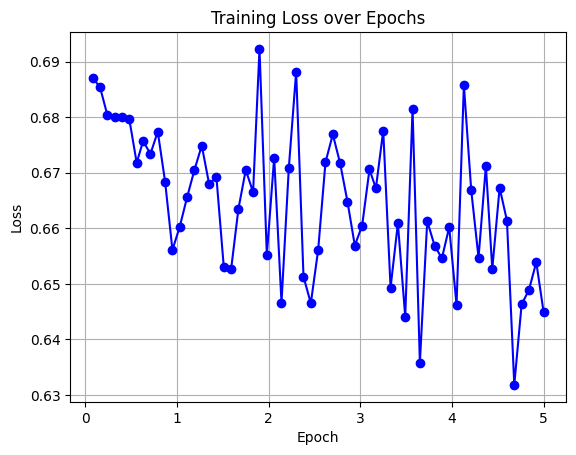

In [ ]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"training_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'training_loss_plot.png')
plt.savefig(loss_plot_path)

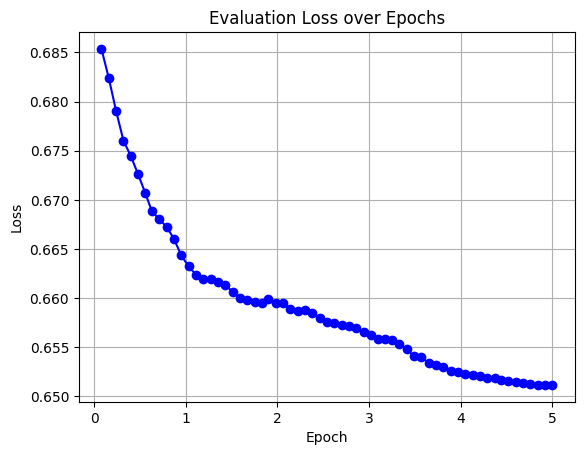

In [ ]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"eval_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['eval_loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Evaluation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'eval_loss_plot.png')
plt.savefig(loss_plot_path)